# Global Analysis Pipeline

## Imports

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import math
pd.set_option('display.max_columns', None)

## Global variables / settings for this notebook

In [36]:
# subject-independant directory and filename of raw-data
input_subject_folder = f"..\\data\\preprocessed\\"
# path to stimuli of experiment
exp_stimuli_folder = "..\\stimuli\\"
# set global colormap var
cmp = plt.cm.viridis_r
# display resolution
display = {"width": 1920, "height": 1080}
# Define the folder name
plt_folder_name = f'..\\plots\\global'# Define the global folder name

In [37]:
# enter subject id of participants you want to include in the global analysis 
global_analysis_subjects = [1, 3, 5, 7, 9, 2, 4, 6, 10]

In [38]:
subj_list = []
for subj in global_analysis_subjects:
    subj_list.append(f"subject-{subj}.tsv")


dframes_list = []
for filename in subj_list:
    df = pd.read_csv(input_subject_folder + filename, sep="\t", header=0)
    dframes_list.append(df)

data = pd.concat(dframes_list, axis=0, ignore_index=True)

In [39]:
def bpog_in_target_bbox(bpogx, bpogy, pos):

    width = display["width"]
    height = display["height"]

    x = bpogx * width
    y = bpogy * height
    
    if pos == "TL":
        relpos = (width/4, height/4)
    elif pos == "TR":
        relpos = (width*(3/4), height/4)
    elif pos == "BL":
        relpos = (width/4, height*(3/4))
    elif pos == "BR":
        relpos = (width*(3/4), height*(3/4))
    else:
        relpos = -1

    pos_x_l = relpos[0] - 200
    pos_x_r = relpos[0] + 200
    pos_y_d = relpos[1] - 200
    pos_y_u = relpos[1] + 200

    if (x > pos_x_l) and (x < pos_x_r):
        if(y > pos_y_d) and (y < pos_y_u):
            return True

    return False


def get_bounding_box_coords(pos):
    
    relpos = 0    
    width = display["width"]
    height = display["height"]


    if pos == "TL":
        relpos = (width/4, height/4)
    elif pos == "TR":
        relpos = (width*(3/4), height/4)
    elif pos == "BL":
        relpos = (width/4, height*(3/4))
    elif pos == "BR":
        relpos = (width*(3/4), height*(3/4))
    else:
        relpos = -1

    pos_x_l = relpos[0] - 200
    pos_x_r = relpos[0] + 200
    pos_y_d = relpos[1] - 200
    pos_y_u = relpos[1] + 200
    
    return (pos_x_l, pos_x_r, pos_y_d, pos_y_u)

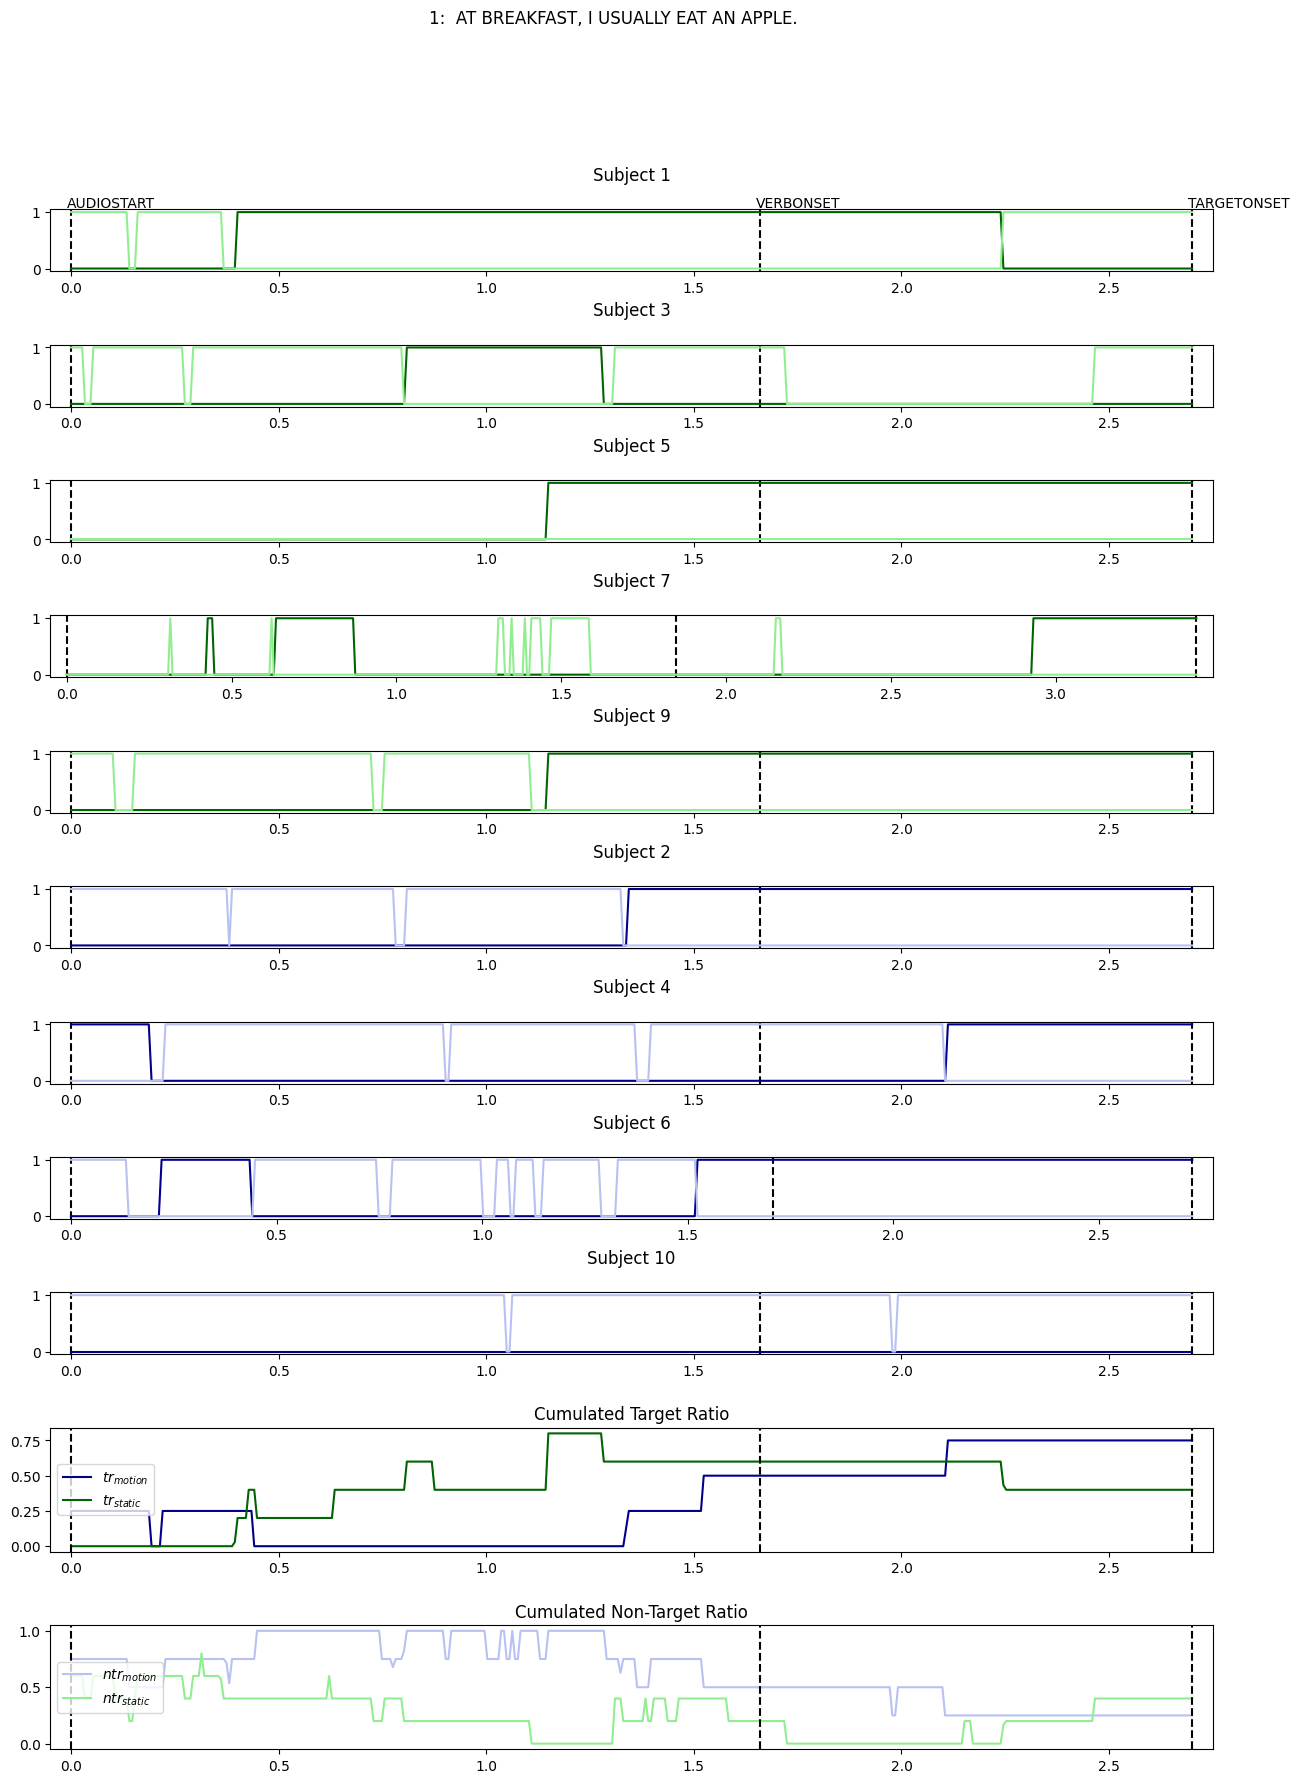

In [40]:
def calc_tr_ntr(data, highlight, sentence_id):

    # init variables
    ratios = [1] * len(global_analysis_subjects)
    ratios.append(2)
    ratios.append(2)

    # get samples with specific id
    data_subset = data.query(f"SENTENCE_ID=={sentence_id}")
    data_subset = data_subset.query(f"EVENT=='AUDIOSTART' or EVENT=='VERBONSET' or EVENT=='TARGETONSET'")

    # filter invalid samples
    data_subset = data_subset.query("BPOGV==1 and BPOGX>=0 and BPOGY >=0")
    data_subset = data_subset.reset_index(drop=True)
    
    # get first row of dataframe
    first_row = data_subset.iloc[0]

    # get general information
    stc = first_row["SENTENCE"]
    t_pos = first_row["TARGET_POS"]
    
    # determin other AOIs
    all_t_pos = ["TL", "TR", "BL", "BR"]
    all_t_pos.remove(t_pos)

    # set tr/ntr for each row
    for index, row in data_subset.iterrows():

        x = row["BPOGX"]
        y = row["BPOGY"]
        in_b_box = bpog_in_target_bbox(x, y, t_pos)
        in_b_box_other = bpog_in_target_bbox(x, y, all_t_pos[0]) or bpog_in_target_bbox(x, y,  all_t_pos[1]) or bpog_in_target_bbox(x, y,  all_t_pos[2])
        
        if in_b_box:
            data_subset.at[index, "TR"] = int(1)
            data_subset.at[index, "NTR"] = int(0)
        else:
            data_subset.at[index, "TR"] = int(0)
            if in_b_box_other:
                data_subset.at[index, "NTR"] = int(1)
            else:
                data_subset.at[index, "NTR"] = int(0)

    # fig 
    fig, ax = plt.subplots(len(global_analysis_subjects)+2, 1, figsize=(15, 20), height_ratios=ratios)
    fig.subplots_adjust(hspace=1)
    
    # subplots
    li = len(global_analysis_subjects)
    for i in range(0, len(global_analysis_subjects)):
        
        subj_no = global_analysis_subjects[i]
        subj_data = data_subset.query(f"SUBJECT=={subj_no}")
        subj_condition = subj_data.query("EVENT=='AUDIOSTART'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "CONDITION"].lower()

        subj_audiostart = subj_data.query("EVENT=='AUDIOSTART'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]
        subj_verbonset = subj_data.query(f"EVENT=='VERBONSET'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"] - subj_audiostart
        subj_targetonset = subj_data.query(f"EVENT=='TARGETONSET'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"] - subj_audiostart
        
        # normalize time for each subject
        for index, row in subj_data.iterrows():
            subj_data.at[index, "TIME"] -= subj_audiostart
            data_subset.at[index, "TIME"] -= subj_audiostart

        # plot subplots for each participant
        ax[i].set_title(f"Subject {subj_no}\n")
        
        ax[i].axvline(x = 0, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
        ax[i].axvline(x = subj_verbonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
        ax[i].axvline(x = subj_targetonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')

        # interpolation necessary because bpogv filters out some samples
        interp_func_tr = interp1d(subj_data['TIME'], subj_data['TR'], kind='linear', fill_value='interpolate')
        interp_func_ntr = interp1d(subj_data['TIME'], subj_data['NTR'], kind='linear', fill_value='interpolate')
        
        lin_num = (subj_targetonset * 150).round(0).astype(int)
        time = np.linspace(0, subj_targetonset, num=lin_num)

        temdf = pd.DataFrame({})
        temdf['TIME'] = time
        temdf['TR'] = interp_func_tr(time).round(0).astype(int)
        temdf['NTR'] = interp_func_ntr(time).round(0).astype(int)
        
        ax[i].plot(temdf["TIME"], temdf["TR"], label=f"$tr_{subj_condition[0]}$", color = "darkgreen" if subj_condition == "static" else "darkblue")
        ax[i].plot(temdf["TIME"], temdf["NTR"], label=f"$ntr_{subj_condition[0]}$", color = "lightgreen" if subj_condition == "static" else "#b8c1f2")

        ax[i].set_xlim((-.05, subj_targetonset+.05))
    
    # text cuenames
    ax[0].text(-0.01, 1.08, 'AUDIOSTART', color = 'grey' if 'a' in highlight else 'k')
    ax[0].text(subj_verbonset-0.01, 1.08, 'VERBONSET', color = 'grey' if 'v' in highlight else 'k')
    ax[0].text(subj_targetonset-0.01, 1.08, 'TARGETONSET', color = 'grey' if 't' in highlight else 'k')

    # final dfs
    static = pd.DataFrame({})
    static_num = 0
    motion = pd.DataFrame({})
    motion_num = 0
    for i in range(0, len(global_analysis_subjects)):
        
        subj_no = global_analysis_subjects[i]
        subj_data = data_subset.query(f"SUBJECT=={subj_no}").copy()
        subj_condition = subj_data.sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "CONDITION"].lower()
        end = subj_data.query("EVENT=='TARGETONSET'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]

        # interpolation necessary because bpogv filters out some samples
        interp_func_tr = interp1d(subj_data['TIME'], subj_data['TR'], kind='linear', fill_value='interpolate')
        interp_func_ntr = interp1d(subj_data['TIME'], subj_data['NTR'], kind='linear', fill_value='interpolate')
        
        lin_num = (end * 150).round(0).astype(int)

        time = np.linspace(0, end, num=lin_num)

        if subj_condition == "motion":
            
            if motion.empty:
                motion['TIME'] = time
                motion['TR'] = interp_func_tr(time)
                motion['NTR'] = interp_func_ntr(time)
            else:
                for index, row in motion.iterrows():
                    motion.at[index, "TR"] += interp_func_tr(row["TIME"]).round(0).astype(int)
                    motion.at[index, "NTR"] += interp_func_ntr(row["TIME"]).round(0).astype(int)
            motion_num += 1

        elif subj_condition == "static":

            if static.empty:
                static['TIME'] = time
                static['TR'] = interp_func_tr(time)
                static['NTR'] = interp_func_ntr(time)
            else:
                for index, row in static.iterrows():
                    static.at[index, "TR"] += interp_func_tr(row["TIME"]).round(0).astype(int)
                    static.at[index, "NTR"] += interp_func_ntr(row["TIME"]).round(0).astype(int)
            static_num += 1
    
    # cummulated plot tr
    ax[li].set_title(f"Cumulated Target Ratio")
    
    ax[li].plot(motion["TIME"], motion["TR"]/motion_num, label="$tr_{motion}$", color = "darkblue")
    ax[li].plot(static["TIME"], static["TR"]/static_num, label="$tr_{static}$", color = "darkgreen")
    
    ax[li].axvline(x = 0, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li].axvline(x = subj_verbonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li].axvline(x = subj_targetonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li].set_xlim((-.05, subj_targetonset+.05))
    ax[li].legend(loc="center left")
    
    # cummulated plot ntr
    ax[li+1].set_title(f"Cumulated Non-Target Ratio")
    
    ax[li+1].plot(motion["TIME"], motion["NTR"]/motion_num, label="$ntr_{motion}$", color = "#b8c1f2")
    ax[li+1].plot(static["TIME"], static["NTR"]/static_num, label="$ntr_{static}$", color = "lightgreen")
    
    ax[li+1].axvline(x = 0, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li+1].axvline(x = subj_verbonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li+1].axvline(x = subj_targetonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li+1].set_xlim((-.05, subj_targetonset+.05))
    ax[li+1].legend(loc="center left")
    
    fig.suptitle(f"{sentence_id}: {stc}")

    plt.show()

    # save plot to assets
    fig.savefig(f'{plt_folder_name}/4-analysis-metrics_{str(sentence_id)}.png')


calc_tr_ntr(data, "", 1)

In [41]:
print(len(data.query("SUBJECT==10")))

98909


##

In [42]:
def calc_tr_ntr_subj(data, subject_no):


    # get samples for user
    data_subset = data.query(f"SUBJECT=={subject_no}")
    # print(subject_no)
    data_subset = data_subset.query(f"EVENT=='AUDIOSTART' or EVENT=='VERBONSET' or EVENT=='TARGETONSET'")
    
    # filter invalid samples
    data_subset = data_subset.query("BPOGX>=0 and BPOGY >=0") #! BPOGV==1 and 
    data_subset = data_subset.reset_index(drop=True)

    # set tr/ntr for each row
    for index, row in data_subset.iterrows():
        
        # get target pos for each sample
        t_pos = row["TARGET_POS"]
        
        # determin other AOIs
        all_t_pos = ["TL", "TR", "BL", "BR"]
        all_t_pos.remove(t_pos)

        x = row["BPOGX"]
        y = row["BPOGY"]
        in_b_box = bpog_in_target_bbox(x, y, t_pos)
        in_b_box_other = bpog_in_target_bbox(x, y, all_t_pos[0]) or bpog_in_target_bbox(x, y,  all_t_pos[1]) or bpog_in_target_bbox(x, y,  all_t_pos[2])

        if in_b_box:
            data_subset.at[index, "TR"] = int(1)
            data_subset.at[index, "NTR"] = int(0)
        else:
            data_subset.at[index, "TR"] = int(0)
            if in_b_box_other:
                data_subset.at[index, "NTR"] = int(1)
            else:
                data_subset.at[index, "NTR"] = int(0)
        
    
    tr_static_cummul = 0
    ntr_static_cummul = 0
    
    tr_motion_cummul = 0
    ntr_motion_cummul = 0

    for sentence_id in range(1, 64+1):

        # print(f"SENTENCE {sentence_id}")

        # print analysis for subject
        stc_data = data_subset.query(f"SENTENCE_ID=={sentence_id}")
        
        subj_condition = stc_data.query("EVENT=='AUDIOSTART'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "CONDITION"].lower()
        # print(f"Analysis for sentence \"{sentence_id}\" ({subj_condition}) for subject {subject_no}")
        
        subj_audiostart = stc_data.query("EVENT=='AUDIOSTART'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]
        subj_targetonset = stc_data.query(f"EVENT=='TARGETONSET'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"] - subj_audiostart
        
        # normalize time for each subject
        for index, row in stc_data.iterrows():
            stc_data.at[index, "TIME"] -= subj_audiostart
            data_subset.at[index, "TIME"] -= subj_audiostart
        
        # interpolation necessary because bpogv filters out some samples
        interp_func_tr = interp1d(stc_data['TIME'], stc_data['TR'], kind='linear', fill_value='interpolate')
        interp_func_ntr = interp1d(stc_data['TIME'], stc_data['NTR'], kind='linear', fill_value='interpolate')
        
        interest_sample = subj_targetonset - 0.05 # 50 ms
        
        if subj_condition == "static":
            tr_static_cummul += interp_func_tr(interest_sample).round(0).astype(int)
            # print(f"static TR+ {interp_func_tr(interest_sample).round(0).astype(int)}")
            ntr_static_cummul += interp_func_ntr(interest_sample).round(0).astype(int)
            # print(f"static NTR+ {interp_func_ntr(interest_sample).round(0).astype(int)}")
        elif subj_condition == "motion":
            tr_motion_cummul += interp_func_tr(interest_sample).round(0).astype(int)
            # print(f"motion TR+ {interp_func_tr(interest_sample).round(0).astype(int)}")
            ntr_motion_cummul += interp_func_ntr(interest_sample).round(0).astype(int)
            # print(f"motion NTR+ {interp_func_ntr(interest_sample).round(0).astype(int)}")
            

    # print(f"TR S CUMMUL {tr_static_cummul}")
    tr_s = tr_static_cummul/32
    tr_m = tr_motion_cummul/32
    # print(f"NTR S CUMMUL {ntr_static_cummul}")
    ntr_s = ntr_static_cummul/32
    ntr_m = ntr_motion_cummul/32
    
    print("Average tr(static): " + str(tr_static_cummul/32))
    print("Average tr(motion): " + str(tr_motion_cummul/32))

    print("Average ntr(static): " + str(ntr_static_cummul/32))
    print("Average ntr(motion): " + str(ntr_motion_cummul/32))
    return (tr_s, tr_m, ntr_s, ntr_m)



# for sb in global_analysis_subjects:
# calc_tr_ntr_subj(data, 3)

In [43]:
rws = []

for i in range(0, len(global_analysis_subjects)):
    subj_no = global_analysis_subjects[i]
    subj_str = f"subject-{subj_no}"
    print(subj_str)
    
    tr_s, tr_m, ntr_s, ntr_m = calc_tr_ntr_subj(data, subj_no)

    rws.append({
        "SUBJECT": subj_no,
        "TR": tr_s,
        "NTR": ntr_s,
        "CONDITION": "STATIC"
    })

    rws.append({
        "SUBJECT": subj_no,
        "TR": tr_m,
        "NTR": ntr_m,
        "CONDITION": "MOTION"
    })

    # if subj_str not in metrics:
    #     metrics[subj_str] = {}

    # metrics[subj_str]["tr_static"] = tr_s
    # metrics[subj_str]["tr_motion"] = tr_m
    # metrics[subj_str]["ntr_static"] = ntr_s
    # metrics[subj_str]["ntr_motion"] = ntr_m

metrics = pd.DataFrame(rws)


subject-1
Average tr(static): 0.4375
Average tr(motion): 0.625
Average ntr(static): 0.4375
Average ntr(motion): 0.34375
subject-3
Average tr(static): 0.5
Average tr(motion): 0.375
Average ntr(static): 0.40625
Average ntr(motion): 0.625
subject-5
Average tr(static): 0.84375
Average tr(motion): 0.75
Average ntr(static): 0.03125
Average ntr(motion): 0.09375
subject-7
Average tr(static): 0.375
Average tr(motion): 0.40625
Average ntr(static): 0.0625
Average ntr(motion): 0.15625
subject-9
Average tr(static): 0.96875
Average tr(motion): 0.84375
Average ntr(static): 0.03125
Average ntr(motion): 0.15625
subject-2
Average tr(static): 0.46875
Average tr(motion): 0.5
Average ntr(static): 0.5
Average ntr(motion): 0.5
subject-4
Average tr(static): 0.5
Average tr(motion): 0.21875
Average ntr(static): 0.4375
Average ntr(motion): 0.71875
subject-6
Average tr(static): 0.65625
Average tr(motion): 0.6875
Average ntr(static): 0.28125
Average ntr(motion): 0.25
subject-10
Average tr(static): 0.6875
Average t

In [44]:
metrics

,SUBJECT,TR,NTR,CONDITION
0,1,0.43750,0.43750,STATIC
1,1,0.62500,0.34375,MOTION
2,3,0.50000,0.40625,STATIC
3,3,0.37500,0.62500,MOTION
4,5,0.84375,0.03125,STATIC
5,5,0.75000,0.09375,MOTION
6,7,0.37500,0.06250,STATIC
7,7,0.40625,0.15625,MOTION
8,9,0.96875,0.03125,STATIC
9,9,0.84375,0.15625,MOTION


In [45]:
stat_tr_dset = metrics.query("CONDITION=='STATIC'")
mean_s = stat_tr_dset["TR"].mean()
print(mean_s)

mot_tr_dset = metrics.query("CONDITION=='MOTION'")
mean_m = mot_tr_dset["TR"].mean()
print(mean_m)

0.6041666666666666
0.5520833333333334


In [46]:
# stdev static
N = len(stat_tr_dset["TR"])
d2 = abs(stat_tr_dset["TR"] - mean_s)**2
var = d2.sum() / (N)
std = var**0.5
print(std)

0.18865385704452953


In [47]:
# stdev motion
N = len(mot_tr_dset["TR"])
d2 = abs(mot_tr_dset["TR"] - mean_m)**2
var = d2.sum() / (N)
std = var**0.5
print(std)

0.18692040046798292


    SUBJECT       TR      NTR CONDITION
0         1  0.43750  0.43750    STATIC
1         1  0.62500  0.34375    MOTION
2         3  0.50000  0.40625    STATIC
3         3  0.37500  0.62500    MOTION
4         5  0.84375  0.03125    STATIC
5         5  0.75000  0.09375    MOTION
6         7  0.37500  0.06250    STATIC
7         7  0.40625  0.15625    MOTION
8         9  0.96875  0.03125    STATIC
9         9  0.84375  0.15625    MOTION
10        2  0.46875  0.50000    STATIC
11        2  0.50000  0.50000    MOTION
12        4  0.50000  0.43750    STATIC
13        4  0.21875  0.71875    MOTION
14        6  0.65625  0.28125    STATIC
15        6  0.68750  0.25000    MOTION
16       10  0.68750  0.18750    STATIC
17       10  0.56250  0.37500    MOTION


(-0.01, 1.01)

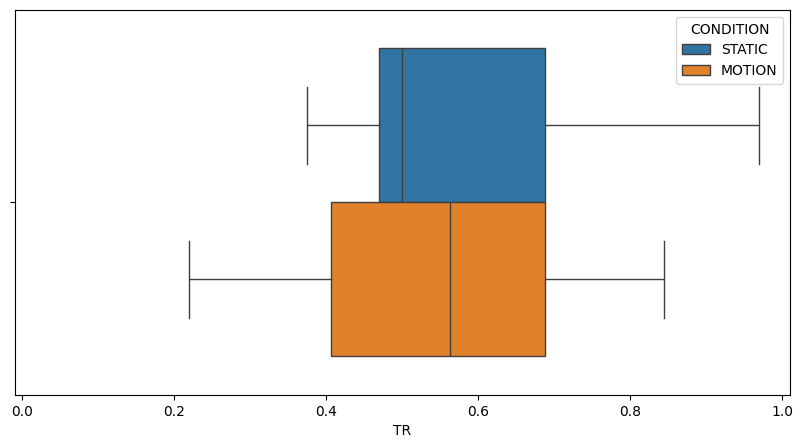

In [48]:
metricsa = metrics
# metricsa = metrics[metrics['SUBJECT'] % 2 == 0]
print(metricsa)


fig = plt.figure(figsize=(10,5))


sns.boxplot(metricsa, x="TR", hue="CONDITION", orient='h')

plt.xlim(-0.01,1.01)

(-0.01, 1.01)

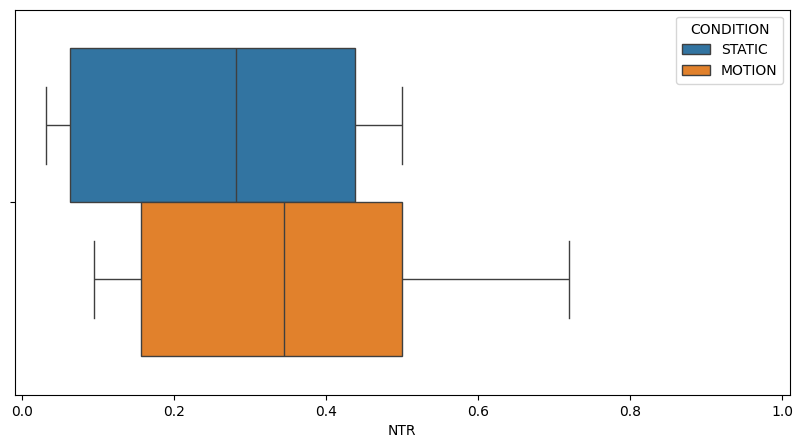

In [49]:
metrics


fig = plt.figure(figsize=(10,5))


sns.boxplot(metrics, x="NTR", hue="CONDITION", orient='h')

plt.xlim(-0.01,1.01)